<a href="https://colab.research.google.com/github/YSindhunata/AI-using-LSTM/blob/main/LSTM_Top_Scorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Path ke dataset
dataset_path = '/content/drive/My Drive/Data/Premier_League_players.csv'

# Membaca dataset
df = pd.read_csv(dataset_path)
df.head(10)

Mounted at /content/drive


,№,Player,Team,Apps,Min,G,A,xG,xA,xG90,xA90
0,1,Son Heung-Min,Tottenham,35,3051,23,7,16.99-6.01,7.85+0.85,0.50,0.23
1,2,Mohamed Salah,Liverpool,35,2757,23,13,24.36+1.36,9.79-3.21,0.80,0.32
2,3,Cristiano Ronaldo,Manchester United,30,2468,18,3,17.21-0.79,4.42+1.42,0.63,0.16
3,4,Harry Kane,Tottenham,37,3229,17,9,20.69+3.69,9.82+0.82,0.58,0.27
4,5,Sadio Mané,Liverpool,34,2833,16,2,16.83+0.83,5.27+3.27,0.53,0.17
5,6,Kevin De-Bruyne,Manchester City,30,2214,15,8,5.95-9.05,11.26+3.26,0.24,0.46
6,7,Jamie Vardy,Leicester,25,1807,15,2,9.99-5.01,1.61-0.39,0.50,0.08
7,8,Diogo Jota,Liverpool,35,2401,15,4,17.35+2.35,5.87+1.87,0.65,0.22
8,9,Wilfried Zaha,Crystal Palace,33,2762,14,1,10.18-3.82,4.89+3.89,0.33,0.16
9,10,Raheem Sterling,Manchester City,30,2119,13,5,15.78+2.78,5.02+0.02,0.67,0.21


# EDA & Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   №       537 non-null    int64  
 1   Player  537 non-null    object 
 2   Team    537 non-null    object 
 3   Apps    537 non-null    int64  
 4   Min     537 non-null    int64  
 5   G       537 non-null    int64  
 6   A       537 non-null    int64  
 7   xG      537 non-null    object 
 8   xA      537 non-null    object 
 9   xG90    537 non-null    float64
 10  xA90    537 non-null    float64
dtypes: float64(2), int64(5), object(4)
memory usage: 46.3+ KB


In [ ]:
df.describe()

,№,Apps,Min,G,A,xG90,xA90
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,269.000000,19.525140,1399.392924,1.931099,1.383613,0.151080,0.106164
std,155.162818,11.643965,1025.156979,3.278847,2.049288,0.348329,0.401948
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,135.000000,9.000000,410.000000,0.000000,0.000000,0.010000,0.010000
50%,269.000000,21.000000,1356.000000,1.000000,1.000000,0.060000,0.060000
75%,403.000000,30.000000,2211.000000,2.000000,2.000000,0.190000,0.140000
max,537.000000,38.000000,3420.000000,23.000000,13.000000,6.310000,8.940000


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
№,0
Player,0
Team,0
Apps,0
Min,0
G,0
A,0
xG,0
xA,0
xG90,0


# Build LSTM Model

In [ ]:
# Features and labels
features = df[['Apps', 'Min', 'G', 'A', 'xG90', 'xA90']].values
labels = df['G'].values

In [ ]:
# Features Normalization
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Tracking original index from dataset
df_indices = df.index

In [ ]:
# Splitting data: 60% train, 20% validation, 20% test
X_train_full, X_test, y_train_full, y_test, train_full_idx, test_idx = train_test_split(
    features_scaled, labels, df_indices, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(
    X_train_full, y_train_full, train_full_idx, test_size=0.25, random_state=42)

In [ ]:
# Reshape data(samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # timesteps = 1
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (321, 1, 6)
Validation shape: (108, 1, 6)
Test shape: (108, 1, 6)


In [ ]:
# Build model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Output untuk regresi
])

model.summary()
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train & evaluate model

In [ ]:
# Train model
history = model.fit(X_train, y_train,
                    epochs=350,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 12.4807 - mae: 1.7501 - val_loss: 14.1314 - val_mae: 1.9938
Epoch 2/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9650 - mae: 1.4603 - val_loss: 13.2372 - val_mae: 1.9528
Epoch 3/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 10.1353 - mae: 1.6355 - val_loss: 12.1921 - val_mae: 1.8980
Epoch 4/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.8080 - mae: 1.5725 - val_loss: 11.0640 - val_mae: 1.8452
Epoch 5/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.0747 - mae: 1.5390 - val_loss: 9.9379 - val_mae: 1.8425
Epoch 6/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.0834 - mae: 1.4850 - val_loss: 8.9651 - val_mae: 1.8595
Epoch 7/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6300 - mae: 1.6604 - val_loss: 8.3414 - val_mae: 1.8785
Epoch 8/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.5771 - mae: 1.7723 - val_loss: 7.8409 - val_mae: 1.8916
Epoch 9/350
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste

In [ ]:
# Evaluate model using MAE & R²
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)
print(f"Test R²: {r2:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0576
Test MAE: 0.05
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Test R²: 1.00


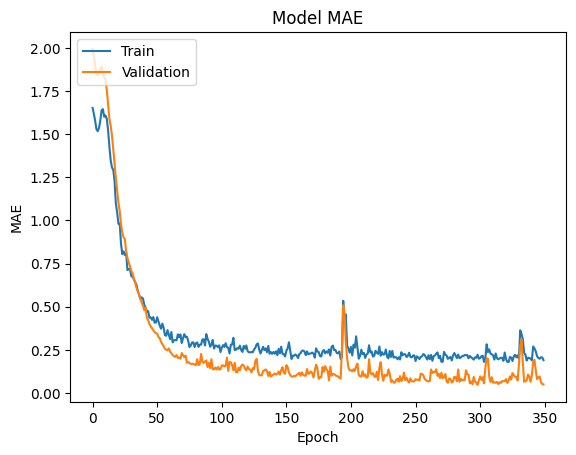

In [ ]:
import matplotlib.pyplot as plt

# Plot MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

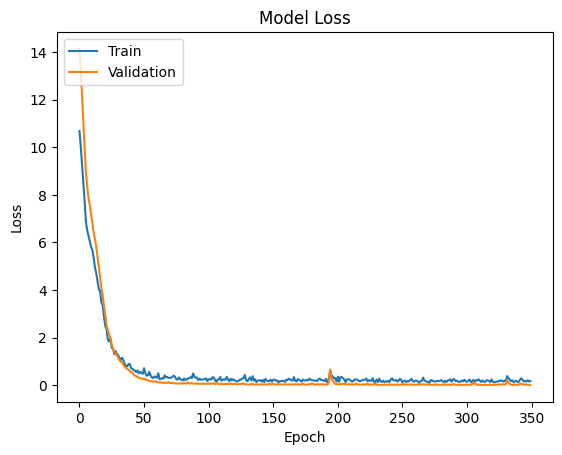

In [ ]:
# Plot R-squared
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Result

In [ ]:
predictions = model.predict(X_test)

test_data = pd.DataFrame(X_test.squeeze(), columns=['Apps', 'Min', 'G', 'A', 'xG90', 'xA90'])
test_data['Player'] = df.loc[test_idx, 'Player'].values
test_data['Actual_Goals'] = y_test
test_data['Predicted_Score'] = predictions.squeeze()

top_scorer = test_data.iloc[test_data['Predicted_Score'].idxmax()]
print("\nPemain yang diprediksi menjadi top scorer:")
print(top_scorer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Pemain yang diprediksi menjadi top scorer:
Apps                    0.918919
Min                     0.892074
G                            1.0
A                       0.538462
xG90                    0.079239
xA90                    0.025727
Player             Son Heung-Min
Actual_Goals                  23
Predicted_Score        22.920891
Name: 84, dtype: object
